# An Analysis of Country Music: The Genre's Stereotypes and The Gender Divide
#### Aditya Kakade (apk67)

## Introduction

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Country music is a genre of music that has existed in the United States since the early 1920s, dating back to the recordings of artists such as Eck Robertson (Citation Here).  As a result, it has a long and convoluted history on the American music scene.  When it comes to the genre's modern day perception, there exist numerous stereotypes regarding the content of country songs that have developed.  As someone who lived in Tennessee during high school, I have been a country music fan for many years.  When I mention my favorite genre to my peers, however, most people express distaste and claim that they could 'never' like it because it explores the same few themes on repeat -- alcohol, the party culture, and surface=level romance (often from the male's perspective).  Upon further research, I discovered that these sentiments about the genre are surprisingly widespread.  Multiple online resources mention perceptions similar to the aforementioned ones of my peers.  SUNY Buffalo's The Record mentions "trucks, beer, country girls, tailgates, fried chicken, boots, [and] the American flag" and Music Times cites a Texas radio station's definition of country music: "You have to have a truck, girl, beer and/or liquor, farm equipment, mud/dust, rural setting like a river, jeans, boots, guns, critters. If you run out of things to talk about, just mention the troops" (Citations Here).

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;To see whether these stereotypes really were that prevalent in country music, I decided to conduct an analysis on the lyrics of around 2500 country songs from 100 'greatest country music artists of all time,' as listed by the staff at Billboard.  The use of 100 artists to collect my dataset of songs was not my initial approach, but ended up being one I had to compromise with (more details in the Corpus, Data & Methods section).  I decided to use topic modeling to identify the most prevalent topics in my dataset, figure out the meaning of each of the topics in terms of music theme, and see if the topics aligned with the stereotypes.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In addition to exploring the themes of my dataset and the genre as a whole, I decided to also explore the differences in male and female artists' country songs.  I wanted to see whether the gender of the song's artist resulted in different themes, different uses of the most frequently used words in country songs, and whether the lyrics of a song could determine what gender the artist was.  This would help analyze whether male and female artists' different perspectives and experiences derived from their gender and society influenced how and what they sang about.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;I will go into more specific hypotheses in the following section -- at a high level, however I expect to find that country music's dominant themes are deeper than those having to do with partying, alcohol, and 'girls.'  I expect that the top topics will be more along the lines of growing up, love, homesickness ... themes that have more of a story to them.  I also expect to find differences between the lyrics of male and female artists' songs -- I expect that the top topics in male artists' songs will be different than their female counterparts, and that we will be able to classify songs into the gender of their artists with moderate accuracy.

## Research Questions & Hypotheses

1. **What are the dominant themes and topics in the country music genre? Do they reflect the societally determined, stereotypical themes of partying, alchol, and females, or are the dominant topics deeper and aligned with topics such as growing up, love, hometowns, and homesickness?**

- Hypothesis: The dominant themes/topics in country music will differ from the societally determined, stereotypical ones.  The most frequently referenced topics will have to do with deeper themes such as growing up, love, hometowns, and homesickness.

2. **Does the gender of a country music artist influence the content of their music? Namely, is there a difference in primary topics for male and female artists, and are the differences enough to be able to classify songs into the gender of their artist based on the lyrics alone?**

- Hypothesis: The primary topics that are present in male and female artists' music will be significantly different in terms of theme.  The differences in each gender's lyrics will be enough to classify songs by their artists' gender.

## Corpus, Data, & Methods

In [20]:
import nltk
import pandas as pd
import numpy as np
#nltk.download('stopwords')
from scipy.stats import entropy
from sklearn.feature_extraction.text import CountVectorizer
from   sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
import time

### The Corpus / Obtaining the Data

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The corpus of song lyrics that is used for this analysis should be representative of the country music genre in the United States.  As a result, the initial approach was to use Billboard's year-end charts to obtain the songs that would make up the dataset.  The 'Hot-100' charts for the Country genre from 2005-2024 would provide song titles and artists, and the lyrics for these songs would be obtained from Genius.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;It was soon discovered, though, that Billboard no longer exposed an API to the public, and that its genre-specific year-end charts from past years were under a $180 paywall.  Even though there were numerouts python libraries claiming to have access to the Billboard charts, none worked anymore and a different approach was used after extensive efforts that yielded no results.  Instead of using each year's 100 most popular country songs as a starting point, Billboard's publicly available of the '100 Greatest Country Singers of All Time' that was created by its staff was used.  Then, each artist's 25 most popular songs would be obtained through Genius, creating a corpus of around 2500 songs.  While this dataset was subject to the opinions of Billboard staff rather than directly determined by the USA's listening habits, Billboard's prevalence and recognized position in the music industry in terms of charts and analysis made it the best choice.  In addition, the artists within the list spanned a wide variety of decades, from Hank Williams Sr (1930-1950) to Kacey Musgraves (2012-Present).  The data collection process is shown in the following cells:

In [ ]:
# Here, I am providing the article URL for the lsit of 100 singers and creating a request/response object

url = 'https://www.billboard.com/lists/best-country-singers/'
headers = {'User-Agent': 'Mozilla/5.0'}
response = requests.get(url, headers=headers)
response.raise_for_status() 

In [ ]:
# Here, I am scraping the list of 100 artists into a python list -- this required manually combing through the webpage
# structure and finding where each name was located
soup = BeautifulSoup(response.text, 'html.parser')
body = soup.find('body', class_="pmc_list-template-default single single-pmc_list postid-1235822070 pmc-gallery__ pmc-desktop pmc-no-tablet pmc-no-mobile geo-us")
main_div = body.find('div', id="main-wrapper")
containing_main = main_div.find('main')
post_div = containing_main.find('div', id = 'post-1235822070')
article = main_div.find('article', class_="a-article-grid__main lrv-u-padding-t-1@mobile-max lrv-a-grid-item u-max-width-100p lrv-u-margin-b-1@desktop u-margin-b-2@desktop-max")
content_div = article.find('div', class_="a-content lrv-a-floated-parent lrv-a-glue-parent a-font-body-m")
not_paywall_div = content_div.find('div', class_="pmc-not-a-paywall")
gallery_div = not_paywall_div.find('div', id="pmc-gallery-vertical")
vertical_div = gallery_div.find('div', class_="c-gallery-vertical-loader u-gallery-app-shell-loader")
ul_element = vertical_div.find('ul', class_='pmc-fallback-list-items lrv-a-unstyle-list lrv-u-margin-t-2')

h2_tags = ul_element.find_all('h2')
artist_names = [h2.get_text(strip=True) for h2 in h2_tags]
artist_names.reverse()

Here, we can see the initial format of the dataframe containing Billboard's 100 greatest country singers of all time.  We then format the names so that they don't include any numbers of punctuation, and save them to a csv:

In [ ]:
artist_names_df = pd.DataFrame(artist_names, columns = ['Artist'])
artist_names_df.head()

In [ ]:
def extract_name(text):
    split_arr = text.split('.')
    name = split_arr[1]
    name = name.strip()
    return name

artist_names_df['Artist'] = artist_names_df['Artist'].apply(lambda x: extract_name(x))
artist_names_df.head()

artist_names_df.to_csv("top_artists.csv", index = False)

Now, it is time to obtain each artist's 25 most popular songs, using Genius's API.  This process was extremely long and arduous, taking around 6 hours because of Genius's API rate limits and some errors only arising after the function had been running for 1 hour.  **Please note, I am not re-running this code in the final submission because it takes 2.5 hours to obtain all of the lyrics from Genius, and I am not providing my API key for security reasons.  To replicate, one can generate their own Genius API key here and run the code.**  The songs each have an artist name, title, and lyrics, which are saved to a local csv.

In [ ]:
def fetch_artist_songs(artist_name, max_songs=5):
    try:
        artist = genius.search_artist(artist_name, max_songs=max_songs, sort="popularity")
        songs = []
        for song in artist.songs:
            song_metadata = genius.search_song(song.title, artist_name)
            release_date = song_metadata.release_date if song_metadata else None
            songs.append({
                "artist": artist_name,
                "song_title": song.title,
                "release_date" : release_date
            })
        time.sleep(1)
        return songs
    
    except Exception as e:
        print(f"Could not find songs for {artist_name}: {e}")
        return []

Before running the function for all 100 artists, we can test it on one artist:

In [ ]:
fetch_artist_songs('Marina Satti', 2)

Obtaining 25 songs for each of the 100 artists:

In [ ]:
all_songs = []

for artist in artist_names_df['Artist']:
    print(f"Fetching songs for {artist}...")
    artist_songs = fetch_artist_songs(artist, max_songs=25)
    all_songs.extend(artist_songs)

songs_df = pd.DataFrame(all_songs)

songs_df.to_csv("songs.csv", index=False)

### Data Cleaning

Even though the song lyrics do not feature lots of text irregularities or aspects that would make analysis difficult, stopwords and bracketed tags that identify parts such as the chorus may still cause confusion in topic modeling and cause the inclusion of words that do not necessarily have any thematic meaning.  As a result, the lyrics were cleaned by removing the aforementioned features, while stopwords will be removed while training models on the data:

In [3]:
country_songs = pd.read_csv("songs.csv")

In [4]:
def clean_structure(lyrics):
    filtered = re.sub(r"\[.*?\]", "", lyrics)
    filtered = re.sub(r"\'", "", filtered)
    filtered = re.sub(r"\s+", " ", filtered).strip()
    return filtered

In [5]:
country_songs = country_songs.dropna()
print(f"Number of songs in dataset: {country_songs.shape[0]}\n")
country_songs['cleaned_lyrics'] = country_songs['lyrics'].apply(lambda x: clean_structure(x))
with pd.option_context('display.max_colwidth', 200):
    print(country_songs['cleaned_lyrics'].sample(5))

Number of songs in dataset: 2344

1406    One by one theyre turning out the lights Ive been feedin that ol jukebox just to hold you tight I guess its for the best I just put in my last dime I heard you whisper "Well meet again, another pl...
1250    I feel so bad, I got a worried mind Im so lonesome all the time Since I left my baby behind On Blue Bayou Saving nickels, saving dimes Working til the sun dont shine Looking forward to happier tim...
806     She was drivin last Friday on the way to Cincinnati On a snow-white Christmas Eve Goin home to see her mama and her daddy With the baby in the backseat Fifty miles to go and she was runnin low On ...
2238    Oh Oh What you doing in this place? Well, I could probably ask you the same thing Another round, girl, what you think? If youre buying, well, you know Ill drink So make it seven on seven Do you wa...
1364    Ill deck my brow with roses My true love may be there And gems that others gave me Shall shine within my hair And even them th

As we can see from the above code cell's output, not all 2500 songs actually had lyrics that could be obtained from Genius.  As a result, after dropping all rows with null entries, we are left with 2344 songs.  While this means the dataset is not extremely large, it is still moderately sized, and can be reprsentative of country music's more popular and renowned songs.  A sample of 5 cleaned song lyrics can also be seen above, showing that the songs have been reduced to just the words, rather than part identifiers.

### Methods/Results: Research Question 1

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Research question 1 involves uncovering the dominant topics, or themes within the corpus of songs to analyze whether or not they fit the stereotypical assumptions regarding country songs' content.  To do this, Latent Dirichlet Allocation was used.  Because LDA is a probabilistic model, it wwill be able to assign each song within the database to a probability distrubution over topics, which are in turn given a probability distribution of words.  This ensures that each song, which can be composed of multiple topics, can be used to identify topics over the corpus as a whole, which can then be ranked according to their frequency in the entire corpus.  The assumptions that LDA makes -- that documents are made up of multiple topics, and topics are made up of multiple words also support its use in this scenario -- different songs may use different words to refer to the same overarching themes, and may also represent more than one theme, and these aspects should not hinder the model but enhance its performance in using the song data to identify all topics and themes!

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;After fitting an LDA model to the dataset, the top words in each topic will be examined, and used to determine what each topic pertains to (what is the 'theme' of each topic).  This will allow comparison with the stereotypical themes.  Topics will also be ranked according to frequency across all songs, to see which topcis are dominant in the corpus as a whole. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Specific implementation details and reasoning will be provided with each code cell below, which fits LDA and uses it to identify dominant topics:

First, we will create a set of stopwords to remove from the corpus during analysis.  In addition to nltk's set of english stopwords, I added some common words that were noticed during a cursory examination of the songs CSV, that do not hold any meaning.

Next, a vectorizer is fitted to the song lyrics.  Words occuring in less than 1 percent of the songs were excluded (since the dataset was already quite small, I did not want to exclude too many words).  Words occuring in more than 70% of the songs were also excluded, to get rid of extremely common words that might also not have as much thematic meaning.

As seen below the cell, this resulted in 1074 features.

In [6]:
stop_words = stopwords.words('english') + ['ive', 'ill', 'youll', 'dont', 'cant', 'thats', 'hes', 'shes', 'im', 'la', 'ooh', 'oh']

vectorizer = CountVectorizer(
    input = 'content',
    encoding = 'utf-8',
    strip_accents = 'unicode',
    stop_words=stop_words,
    lowercase = True,
    min_df = 0.01,
    max_df = 0.70
)

cleaned_songs = country_songs['cleaned_lyrics'].tolist()
X = vectorizer.fit_transform(cleaned_songs)

print(f'Number of features: {X.shape[1]}')

Number of features: 1074


Next, an LDA model was fitted to the corpus.  We want to get a comprehensive look at the different topic possiblities within all of the song lyrics, but must balance this with the fact that there are ontly 2344 songs within the dataset.  As a result, I decided to search for 15 topics, and left max iteration at the default value of 10 which should be sufficient to refine topic assignments for the smaller dataset.

In [31]:
lda = LatentDirichletAllocation(
    n_components=10,
    n_jobs=-1,       
    verbose=1,       
    max_iter=20,     
    evaluate_every=0
)

lda.fit(X)

iteration: 1 of max_iter: 20
iteration: 2 of max_iter: 20
iteration: 3 of max_iter: 20
iteration: 4 of max_iter: 20
iteration: 5 of max_iter: 20
iteration: 6 of max_iter: 20
iteration: 7 of max_iter: 20
iteration: 8 of max_iter: 20
iteration: 9 of max_iter: 20
iteration: 10 of max_iter: 20
iteration: 11 of max_iter: 20
iteration: 12 of max_iter: 20
iteration: 13 of max_iter: 20
iteration: 14 of max_iter: 20
iteration: 15 of max_iter: 20
iteration: 16 of max_iter: 20
iteration: 17 of max_iter: 20
iteration: 18 of max_iter: 20
iteration: 19 of max_iter: 20
iteration: 20 of max_iter: 20


LatentDirichletAllocation(evaluate_every=0, max_iter=20, n_jobs=-1, verbose=1)

To get an idea for what broader theme each topic represents, we can look at the top 10 words for each topic, by obtaining the feature names from the vectorizer, and placing word frequencies in a dictionary.  For each topic, we can look at the indices of the top words in each topic, and print them for analysis.

In [32]:
n_top_words = 20
feature_names = vectorizer.get_feature_names_out()

topics = lda.components_

word_counts = np.asarray(X.sum(axis=0)).flatten()

word_freq_dict = {word: word_counts[idx] for idx, word in enumerate(feature_names)}

top_words_per_topic = []
for topic_idx, topic in enumerate(topics):
    top_indices = topic.argsort()[:-n_top_words - 1:-1]
    top_words = [(feature_names[i], topic[i], word_freq_dict[feature_names[i]]) for i in top_indices]
    top_words_per_topic.append((f"Topic {topic_idx + 1}", top_words))

Before attempting to discernt the theme of each topic, we can better visualize each of the fifteen topics and their top words by plotting the word's frequencies in the topic and in the corpus as a whole:

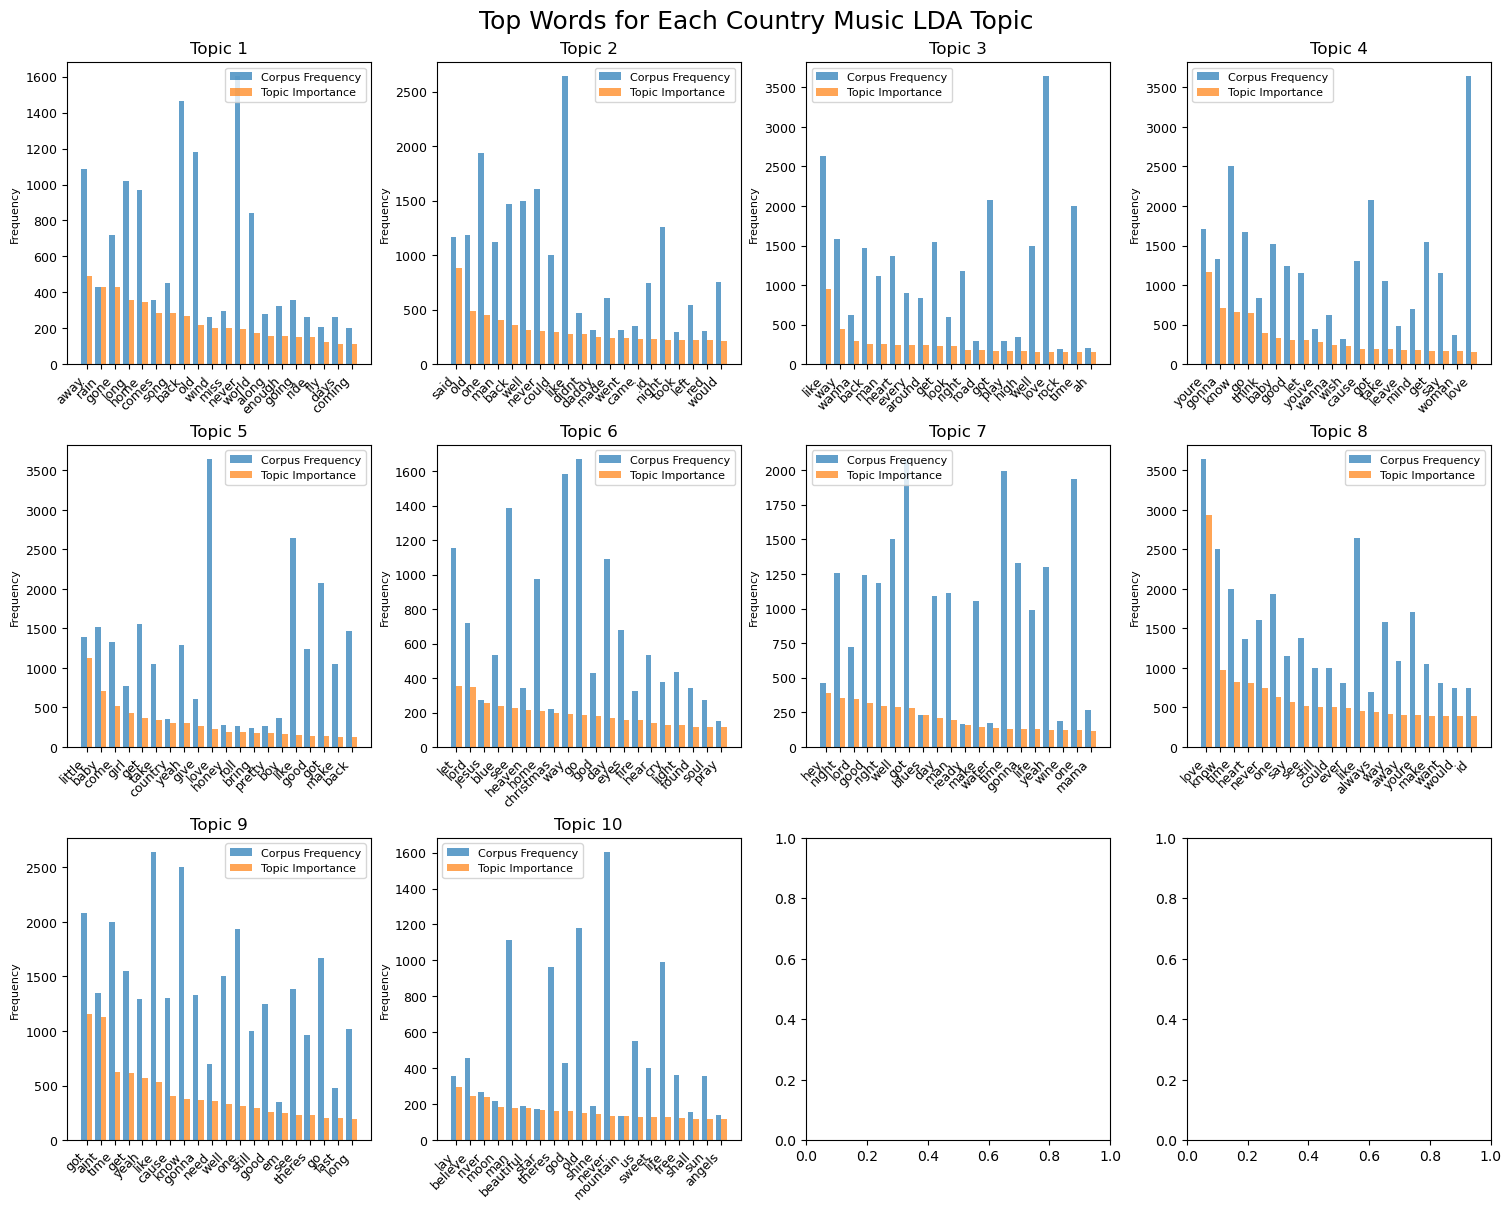

In [33]:
n_topics = len(top_words_per_topic)
n_top_words = 15

n_rows = 3
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12), constrained_layout=True)
axes = axes.flatten()

for idx, (topic_name, topic_words) in enumerate(top_words_per_topic):
    ax = axes[idx]
    words, topic_scores, corpus_freqs = zip(*topic_words)
    
    x = np.arange(len(words))
    ax.bar(x - 0.2, corpus_freqs, width=0.4, label='Corpus Frequency', alpha=0.7)
    ax.bar(x + 0.2, topic_scores, width=0.4, label='Topic Importance', alpha=0.7)
    
    ax.set_xticks(x)
    ax.set_xticklabels(words, rotation=45, ha='right', fontsize=10)
    ax.set_title(topic_name, fontsize=12)
    ax.set_ylabel("Frequency", fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=9)
    ax.legend(fontsize=8)

fig.suptitle("Top Words for Each Country Music LDA Topic", fontsize=18)
plt.show()

For each of the 10 topics, we can attempt to discern the broader theme by looking at the 15 most frequent words.  While extremely specific themes might not be discernible, we should still be able to get a good idea of what each topic is generally about:

1. Topic 1 sees the use of words such as 'away,' 'gone,' 'rain,' 'miss,' and 'coming.'  Overall, these words suggest a theme that has to do with being away from, or the absence of a person or place, and the negative emotions that may come with this.

2. Topic 2 sees the use of words such as 'said,' 'old,' 'man,' 'daddy,' 'night,' 'took,' and 'left.'  This theme is less discernible than topic 1, but seems to be along the lines of a male/father figure and their words and actions.

3. Topic 3 sees the use of words such as 'like,' 'way,' 'man,' 'heart,' 'night,' and 'love.'  This theme appears to have more to do with romance, from the perpsective of someone interested in a man/male figure.

4. Topic 4 sees the use of words such as 'youre,' 'gonna,' 'wish,' 'know,' 'leave,' and 'woman.'  This topic seems to have to do with a person leaving (most likely a woman) a relationship/situation and any consequences that may arise from that.

5. Topic 5 sees the use of words such as 'little,' 'baby,' 'love,' 'honey,' 'country,' 'pretty,' 'girl,' and 'roll.'  This theme appears to have more to do with females in a romantic light, from the perspective of someone interested in them.

6. Topic 6 sees the use of words such as 'lord,' 'jesus,' 'christmas,' 'god,' 'heaven,' 'soul,' 'fire,' and 'pray.'  This is definitely a topic that has a more religious theme, having to do with heaven, hell, and god from a Christian perspective.

7. Topic 7 sees the use of words such as 'night,' 'lord,' 'water,' 'wine,' 'time,' and 'mama.'  This topic is a difficult one to analyze -- the inclusion of lord, water, and wine suggest religious overtones, but other words imply that this is not the topic's exclusive theme.

8. Topic 8 sees the use of words such as 'love,' 'know,' 'time,' 'never,' 'say,' 'make,' and 'want.'  This topic is most likely a return to a theme having to do more with romance, perhaps in the context of time and the unsaid.

9. Topic 9 sees the use of words such as 'got,' 'time,' 'know,' 'need,' 'last,' 'still,' and 'long.'  This theme seems to have to do with time , knowledge, needs and the possession of them.

10. Topic 10 sees the use of words such as 'lay,' 'believer,' 'moon,' 'beautiful,' 'star,' 'mountain,' 'sun,' 'life,' 'god,' 'angels,' and 'free.'  This theme suggests something aligning with nature, but in a religious context -- perhaps an appreciation of the environment/surroundings in the context of creation and religion.

We can also view which topics were the most frequent in the corpus as a whole, to get a better idea for the genre's dominant themes by plotting topic frequencies:

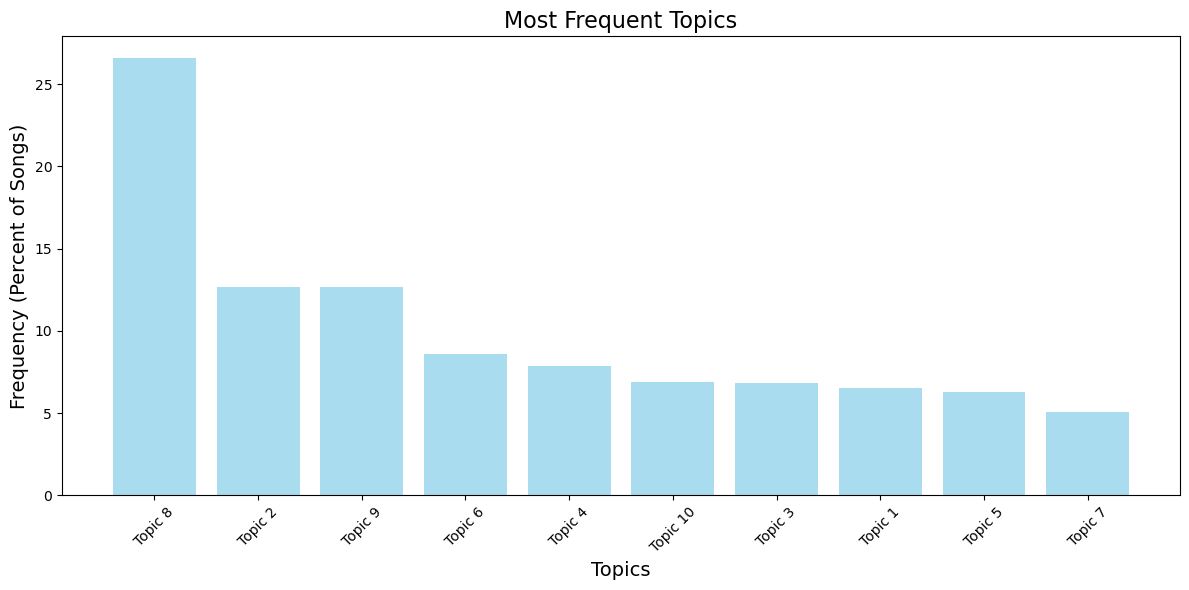

In [34]:
doc_topic_matrix = lda.transform(X)

topic_frequencies = doc_topic_matrix.sum(axis=0)

topic_frequencies_percentage = (topic_frequencies / topic_frequencies.sum()) * 100

sorted_topic_indices = np.argsort(topic_frequencies_percentage)[::-1]

plt.figure(figsize=(12, 6))
plt.bar(
    [f"Topic {i + 1}" for i in sorted_topic_indices],
    topic_frequencies_percentage[sorted_topic_indices],
    color="skyblue",
    alpha=0.7
)
plt.title("Most Frequent Topics", fontsize=16)
plt.xlabel("Topics", fontsize=14)
plt.ylabel("Frequency (Percent of Songs)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

https://www.loc.gov/collections/songs-of-america/articles-and-essays/musical-styles/popular-songs-of-the-day/country/#:~:text=The%20first%20commercial%20country%20music,Sallie%20Gooden%22%20for%20Victor%20Records.


By far the most frequent topic in the corpus is Topic 8, a topic that appears to be romantic in terms of its theme.  The next two most frequent topics are 2 and 9, which have to do with male/father figure's words and actions, and aspects of a human's knowledge and needs in the context of time respectively.

Because LDA is unsupervised, it is difficult to conduct traditional tests of statistical significance on topic modeling.  However, we can look at the identified topics in relation to eachother, to see how distinct they actually are.  I decided to use this using KL divergence, which measures the difference between probablity distributions.  This made sense to use as a measure of distinctiveness between topics, because each topic is essentially a probability distribution of words, and topics are assumed to be distributed over documents as well.  To calculate this, I calculated the kl diverjence between each pair of topics, using entropy, and visualized the results in the below matrix:

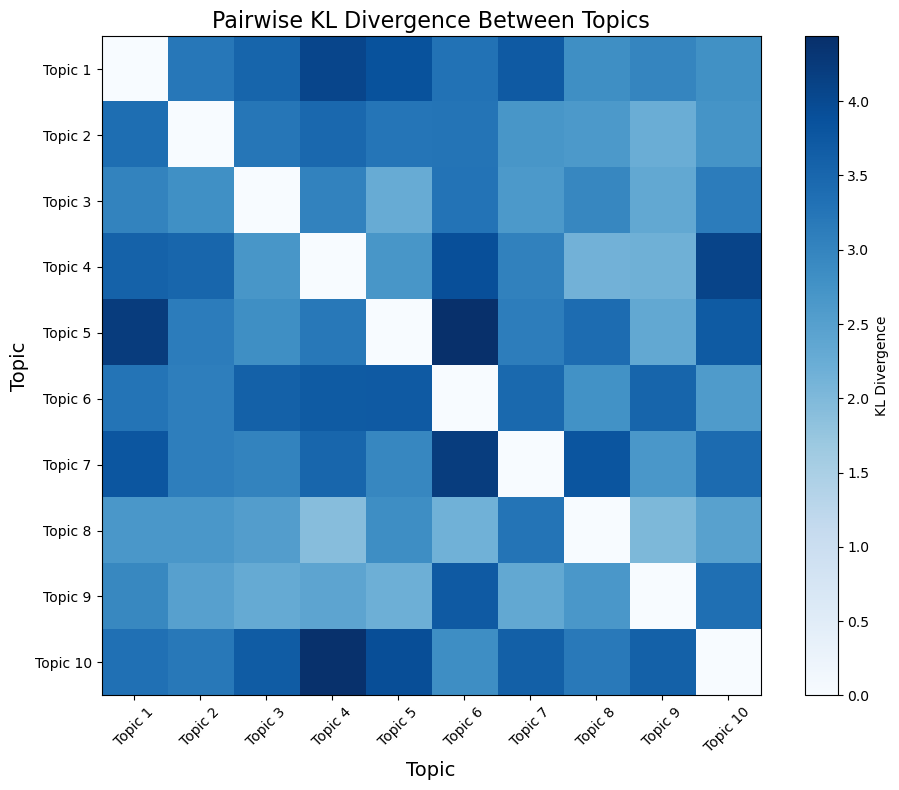

In [36]:
normalized_topic_distributions = topics / topics.sum(axis=1, keepdims=True)

n_topics = normalized_topic_distributions.shape[0]
pairwise_kl = np.zeros((n_topics, n_topics))

for i in range(n_topics):
    for j in range(n_topics):
        if i != j: 
            pairwise_kl[i, j] = entropy(normalized_topic_distributions[i], normalized_topic_distributions[j])

plt.figure(figsize=(10, 8))
plt.imshow(pairwise_kl, interpolation='nearest', cmap='Blues')
plt.colorbar(label='KL Divergence')
plt.title("Pairwise KL Divergence Between Topics", fontsize=16)
plt.xlabel("Topic", fontsize=14)
plt.ylabel("Topic", fontsize=14)
plt.xticks(range(n_topics), [f"Topic {i+1}" for i in range(n_topics)], rotation=45)
plt.yticks(range(n_topics), [f"Topic {i+1}" for i in range(n_topics)])
plt.tight_layout()
plt.show()


A higher KL divergence means a greater difference in distributions, and distinction between topics.  As we can see from the matrix, there are some topic pairs that are extremely distinct, such as 10 and 4, 5 and 6, and 7 and 6.  For context, 10 has to do with nature in the context of religion, 4, has to do with romance and particularly a woman leaving, 7 is possibly religious, and 6 seems to be more purely about religion (mentions heaven, hell, and jesus).

It is important to note though, that most pairwise differences ahave KL divergences of around 2.5 and above, suggesting that they are above moderately to significantly distinct from eachother.  This instills some confidence that the LDA model was actually able to identify distinct topics that are still representative of the entire corpus as a whole.

## Discussion & Conclusions: Hypothesis 1

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The purpose of this analysis was to determine whether or not the dominant topics and themes in the Country Music genre aligned with the stereotypical assumptions about the genre -- that country songs mostly discuss themes having to do with partying, alcohol, and women from the perspective of men.  Using LDA, we obtained 10 topics from the corpus of song lyrics.  Of the 10 topics, whose likely meanings were discussed above, topic5 did seem to align with the stereotypes that are assumed by society.  Topic 5 was especially reminiscent, as its most frequent words suggested a theme that covered women in a romantic light, from the perspective of someone that would be attracted to them (most likely a man, due to the nature of country music).  This is supported by the inclusion of words such as 'little,' 'baby,' 'love,' 'honey,' 'country,' 'pretty,' 'girl,' and 'roll.'  However, all of the other topics seemed to diverge from the stereotypical themes.  As seen from the above analyses of each topic, topic 1 appears to be about loss and absence of persons or places; topics 2 and 3 appear to be more about male figures -- both from the romantic perspective and 'guiding presence' perspective; topic 4 concerns romance involving women, but less from a perspective like topic 5's and more from the point of view of someone who they were leaving; topics 8 and 9 have more to do with time in some capacity; and topics 6, 10, and 7 all have religious themes -- 6 being overtly religious in the traditional Christian sense, 10 applying religion to nature, and 7 being harder to categorize definitively.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The research question and hypothesis also involved looking at the most prominent themes in the Country Music genre.  Topic 8 was by far the most common, being present in around 27% of the songs in the dataset.  The next most frequent topics were 2 and 9, being present in 12.5% of the songs in the dataset.  The rest of the topics were far less frequent, ranging from being present in around 8% of the songs (Topic 6) to 5% of the songs (Topic 7).  It is interesting to see, however, that the most 'stereotype-aligned' topic (5), was the 9th most frequent.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;While statstical significance was not as easy to test for an unsupervised model such as LDA, the topic/themes' distinctiveness from eachother was still considered.  To do this, the KL divergence for each pair of topics was calculating using entropy, to see how different each topic's distribution was from all of the other topics.  This serves as a marker for seeing how effective LDA was at actually identifying a diverse group of topics when it comes to their content.  The most distinct topic pairs (those with KL divergence values of above 4) are: (5 & 1), (5 & 6), (6 & 7) and (10 & 4).   This makes sense, given their themes that were derived from the most frequent words.  5 is about women in a more stereotypical light, referring to them as 'honey' and discussing their appearances such as them being 'pretty' -- a stark contrast from the negative emotional tone of 1 and the overtly religious tone of 6.  6 having such a high divergence value from 7 destroys the earlier conclusion that 7 is a religious theme -- if it is, it is very loosely religious, and still very difficult to classify.  And finally, 10 & 4 being so different also makes sense, given 10 involves religion and nature, while 4 appears to involve romance in the negative light of a partner leaving.  The lowest KL divergence value in the matrix is definitely seen between topic 8 and topic 4, and both of these topics discuss romance in a less positive light that has to do with leaving and the unsaid.  Overall, though the KL divergence values are reasonably high -- with most ranging from 2.5 to 4.  This suggests reasonable distinctiveness of topics, suggesting that LDA identified ones that highlight multiple different undertones in the corpus of country music lyrics.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Taking all of this into account, we can make a few observations.  One is that of the 10 distinct topics, only one (5) was overtly aligned with the stereotypical expectations of Country Music that were discussed in the Introduction and Research Question/Hypothesis sections.  Out of all of the topics, this was also the 9th most frequently occuring in the country song lyrics corpus as a whole (it only was present in around 6% of songs).  Even though this suggests that Topic 5 specifically does not represent a very prevalent theme in the dataset, and the KL divergence matrix highlights stark differences between it and other topics, **it is not enough to prove or disprove my hypothesis, or the notion that country music follows societally determined, stereotypical themes of partying, alchol, and females more than others.**  This is because the interpretation of the 10 topics obtatined from the LDA model was much more subjective than intially hoped for.  I expected much more distinct and suggestive words in most topics, rather than having to discern vaguer themes in some of the topics that may or may not be correct representations.  As a result, it cannot be said for sure whether stereotypical themes truly weren't present in the dataset, other than that seen in Topic 5.  In addition, my dataset may cause a limitation in terms of applicablity to the Country Music genre as a whole, which will be further discussed in the Limitations section.